# A Recommendation Engine for The Recipes by Using Collaborative Filtering in Python

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics.pairwise import pairwise_distances

In [2]:
I = pd.read_csv('./Data_Source/interactions_train.csv')
R = pd.read_csv('./Data_Source/RAW_recipes.csv')
I.info()
R.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698901 entries, 0 to 698900
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    698901 non-null  int64  
 1   recipe_id  698901 non-null  int64  
 2   date       698901 non-null  object 
 3   rating     698901 non-null  float64
 4   u          698901 non-null  int64  
 5   i          698901 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 32.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 

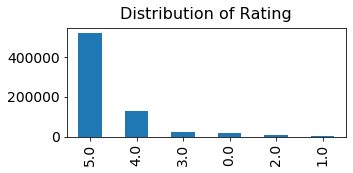

In [3]:
I.rating.value_counts().plot(kind = 'bar', fontsize = 14,
                             figsize = (5,2)).set_title('Distribution of Rating',
                                                        fontsize = 16, ha = 'center', va = 'bottom')

plt.show()

## Clean up the data

In [4]:
_all = I.drop(['date', 'u', 'i'], axis = 1)
_all

,user_id,recipe_id,rating
0,2046,4684,5.0
1,2046,517,5.0
2,1773,7435,5.0
3,1773,278,4.0
4,2046,3431,5.0
...,...,...,...
698896,926904,457971,5.0
698897,2002312797,27208,5.0
698898,1290903,131607,5.0
698899,226867,363072,5.0


In [5]:
grouped_1 = _all.groupby(['user_id'], as_index = False, sort = False).agg({'recipe_id':'count'}).reset_index(drop = True)
grouped_1 = grouped_1.rename(columns = {'recipe_id':'reviews_count'})
grouped_1 = grouped_1.sort_values('reviews_count', ascending = False).iloc[:7500,:]
grouped_1

,user_id,reviews_count
9980,424680,6437
575,37449,4581
9338,383346,3656
4264,169430,3465
3146,128473,3338
...,...,...
8361,308507,13
2096,71854,13
10093,99254,13
5853,228313,13


In [6]:
grouped_2 = _all.groupby(['recipe_id'], as_index = False, sort = False).agg({'user_id':'count'}).reset_index(drop = True)
grouped_2 = grouped_2.rename(columns = {'user_id':'reviews_count'})
grouped_2 = grouped_2.sort_values('reviews_count', ascending = False).iloc[:7500,:]
grouped_2

,recipe_id,reviews_count
2669,27208,1091
21058,89204,1075
3620,32204,897
5995,39087,894
18739,69173,787
...,...,...
63326,214917,14
48452,160457,14
20168,83642,14
42123,19766,14


In [7]:
_part = pd.merge(_all.merge(grouped_1).drop(['reviews_count'], axis = 1), grouped_2).drop(['reviews_count'], axis = 1)
_part

,user_id,recipe_id,rating
0,2312,2886,5.0
1,11044,2886,5.0
2,9869,2886,5.0
3,22655,2886,3.0
4,26313,2886,4.0
...,...,...,...
222248,2198132,518229,5.0
222249,2209000,518229,5.0
222250,2200124,518229,5.0
222251,2192609,518229,5.0


In [8]:
print('unique users:',len(_part.user_id.unique()))
print('unique recipes:',len(_part.recipe_id.unique()))

unique users: 7481
unique recipes: 7500


In [9]:
grouped_user = _part.groupby(['user_id'], as_index = False, sort = False).agg({'recipe_id':'count'}).reset_index(drop = True)
grouped_user = grouped_user.rename(columns = {'recipe_id':'reviews_count'})

grouped_recipe = _part.groupby(['recipe_id'], as_index = False, sort = False).agg({'user_id':'count'}).reset_index(drop = True)
grouped_recipe = grouped_recipe.rename(columns = {'user_id':'reviews_count'})

display(grouped_user[['reviews_count']].describe())
display(grouped_recipe[['reviews_count']].describe())

,reviews_count
count,7481.000000
mean,29.708996
std,49.227948
min,1.000000
25%,9.000000
50%,15.000000
75%,30.000000
max,1366.000000


,reviews_count
count,7500.000000
mean,29.633733
std,36.224671
min,5.000000
25%,15.000000
50%,19.000000
75%,30.000000
max,708.000000


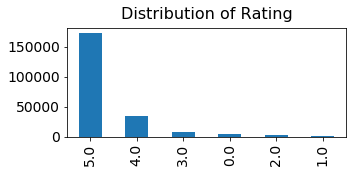

In [10]:
_part.rating.value_counts().plot(kind = 'bar', fontsize = 14, 
                                            figsize = (5,2)).set_title('Distribution of Rating',
                                                                      fontsize = 16, ha = 'center', va = 'bottom')

plt.show()

In [11]:
new_userID = dict(zip(list(_part['user_id'].unique()),
                      list(range(len(_part['user_id'].unique())))))
display(new_userID)

new_recipeID = dict(zip(list(_part['recipe_id'].unique()),
                      list(range(len(_part['recipe_id'].unique())))))
display(new_recipeID)

{2312: 0,
 11044: 1,
 9869: 2,
 22655: 3,
 26313: 4,
 25455: 5,
 25792: 6,
 10033: 7,
 8688: 8,
 28397: 9,
 29014: 10,
 30209: 11,
 29063: 12,
 42058: 13,
 43505: 14,
 32772: 15,
 60989: 16,
 55589: 17,
 64583: 18,
 30228: 19,
 76074: 20,
 85714: 21,
 88717: 22,
 96436: 23,
 93997: 24,
 25941: 25,
 101376: 26,
 59588: 27,
 98919: 28,
 92641: 29,
 111347: 30,
 91584: 31,
 126104: 32,
 60716: 33,
 135887: 34,
 121852: 35,
 122175: 36,
 144671: 37,
 148715: 38,
 130513: 39,
 140806: 40,
 155675: 41,
 155595: 42,
 142386: 43,
 162086: 44,
 163601: 45,
 172369: 46,
 168087: 47,
 162725: 48,
 184081: 49,
 188119: 50,
 189475: 51,
 99221: 52,
 186979: 53,
 194611: 54,
 203111: 55,
 201064: 56,
 207375: 57,
 207176: 58,
 215350: 59,
 218535: 60,
 217226: 61,
 215260: 62,
 227039: 63,
 224088: 64,
 124268: 65,
 143721: 66,
 235074: 67,
 203741: 68,
 257993: 69,
 259154: 70,
 145130: 71,
 246482: 72,
 269891: 73,
 297557: 74,
 272300: 75,
 302961: 76,
 267665: 77,
 307059: 78,
 315635: 79,
 2582

{2886: 0,
 3368: 1,
 11020: 2,
 9254: 3,
 13619: 4,
 15364: 5,
 15654: 6,
 14337: 7,
 18513: 8,
 20492: 9,
 16698: 10,
 33454: 11,
 37490: 12,
 31639: 13,
 18487: 14,
 45539: 15,
 35779: 16,
 35547: 17,
 52840: 18,
 61718: 19,
 19901: 20,
 75817: 21,
 14359: 22,
 39911: 23,
 86868: 24,
 65131: 25,
 106251: 26,
 109283: 27,
 21761: 28,
 132411: 29,
 109006: 30,
 202935: 31,
 239592: 32,
 200008: 33,
 5478: 34,
 55680: 35,
 24709: 36,
 79462: 37,
 17300: 38,
 55394: 39,
 53767: 40,
 83287: 41,
 51235: 42,
 37638: 43,
 118475: 44,
 30018: 45,
 70224: 46,
 63750: 47,
 57033: 48,
 90822: 49,
 213535: 50,
 2713: 51,
 17222: 52,
 3400: 53,
 19596: 54,
 24685: 55,
 4368: 56,
 40621: 57,
 8599: 58,
 12668: 59,
 29184: 60,
 18651: 61,
 18829: 62,
 23116: 63,
 19590: 64,
 23195: 65,
 25254: 66,
 11489: 67,
 33386: 68,
 30864: 69,
 21256: 70,
 50342: 71,
 37037: 72,
 37199: 73,
 51919: 74,
 67777: 75,
 45940: 76,
 30644: 77,
 38305: 78,
 27809: 79,
 59183: 80,
 47413: 81,
 29493: 82,
 46597: 83,
 

In [12]:
df = _part.replace({'user_id': new_userID, 'recipe_id': new_recipeID})
df

,user_id,recipe_id,rating
0,0,0,5.0
1,1,0,5.0
2,2,0,5.0
3,3,0,3.0
4,4,0,4.0
...,...,...,...
222248,7465,7499,5.0
222249,7475,7499,5.0
222250,7469,7499,5.0
222251,7472,7499,5.0


In [13]:
print('The recipes without names: ', R['id'][R['name'].isnull()].values[0])
display(df[df['recipe_id'] == R['id'][R['name'].isnull()].values[0]])

The recipes without names:  368257


,user_id,recipe_id,rating


In [16]:
recipe = R[['name', 'id', 'ingredients']].merge(_part[['recipe_id']], 
                                                left_on = 'id', right_on = 'recipe_id', 
                                                how = 'right').drop(['id'], axis = 1).drop_duplicates().reset_index(drop = True)
recipe

,name,ingredients,recipe_id
0,best banana bread,"['butter', 'granulated sugar', 'eggs', 'banana...",2886
1,blackberry pie iii,"['sugar', 'all-purpose flour', 'cornstarch', '...",3368
2,casablanca chicken,"['boneless skinless chicken breasts', 'olive o...",11020
3,grilled salmon,"['fresh salmon', 'butter', 'garlic', 'salt', '...",9254
4,homemade pie crust,"['all-purpose flour', 'salt', 'butter', 'cold ...",13619
...,...,...,...
7495,cheesy potato italian sausage balls 5fix,['simply potatoes traditional mashed potatoes'...,496573
7496,cheddar stuffed potato cake and egg 5fix,"['olive oil', 'simply potatoes traditional mas...",497382
7497,quick and easy crabby caesar salads 5fix,"['complete caesar salad in a bag', 'simply pot...",497261
7498,mac n cheese and spinach strata sp5,"['simply macaroni & cheese', 'frozen spinach',...",514423


In [14]:
print('unique users:',len(_part.user_id.unique()))
print('unique recipes:',len(_part.recipe_id.unique()))

unique users: 7481
unique recipes: 7500


In [15]:
mean = df.groupby(['user_id'], as_index = False, sort = False).mean().rename(columns = {'rating':'rating_mean'})
df = df.merge(mean[['user_id','rating_mean']], how = 'left')
df.insert(2, 'rating_adjusted', df['rating'] - df['rating_mean'])
df

,user_id,recipe_id,rating_adjusted,rating,rating_mean
0,0,0,0.382353,5.0,4.617647
1,1,0,0.304348,5.0,4.695652
2,2,0,0.088319,5.0,4.911681
3,3,0,-1.031250,3.0,4.031250
4,4,0,-0.692308,4.0,4.692308
...,...,...,...,...,...
222248,7465,7499,0.588235,5.0,4.411765
222249,7475,7499,0.000000,5.0,5.000000
222250,7469,7499,0.357143,5.0,4.642857
222251,7472,7499,0.384615,5.0,4.615385


In [17]:
train_data, test_data = train_test_split(df, test_size = 0.25)
display(train_data)
display(test_data)

,user_id,recipe_id,rating_adjusted,rating,rating_mean
206051,587,6522,0.080000,5.0,4.920000
108651,3547,2621,-1.666667,3.0,4.666667
167535,2244,4676,0.320513,5.0,4.679487
113818,1101,2815,0.000000,5.0,5.000000
142910,6757,3776,0.272727,5.0,4.727273
...,...,...,...,...,...
180780,5208,5266,0.769231,5.0,4.230769
216461,3792,7115,0.395062,5.0,4.604938
101910,2961,2398,0.409091,5.0,4.590909
31257,6255,516,0.000000,5.0,5.000000


,user_id,recipe_id,rating_adjusted,rating,rating_mean
24538,3550,431,-0.895161,4.0,4.895161
155058,478,4204,-0.456522,4.0,4.456522
172188,468,4883,0.113333,5.0,4.886667
213009,4508,6913,1.050000,5.0,3.950000
94272,3030,2150,-0.925000,4.0,4.925000
...,...,...,...,...,...
198286,770,6104,-0.301370,4.0,4.301370
128,128,0,0.571429,5.0,4.428571
182586,352,5349,0.133087,5.0,4.866913
28157,2833,477,0.066667,5.0,4.933333


In [18]:
n_users = df.user_id.unique()
n_items = df.recipe_id.unique()

train_data_matrix = np.zeros((n_users.shape[0], n_items.shape[0]))
for row in train_data.itertuples():
    train_data_matrix[row[1]-1, row[2]-1] = row[3]

display(train_data_matrix.shape)
display(train_data_matrix)

(7481, 7500)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.30434783],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.08831909],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.38235294, 0.        , 0.38235294, ..., 0.        , 0.        ,
        0.        ]])

In [19]:
test_data_matrix = np.zeros((n_users.shape[0], n_items.shape[0]))
for row in test_data.itertuples():
    test_data_matrix[row[1]-1, row[2]-1] = row[3]

display(test_data_matrix.shape)
display(test_data_matrix)

(7481, 7500)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -1.03125   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.38235294,  0.        , ...,  0.        ,
         0.        ,  0.38235294]])

## Centered cosine similarity

In [20]:
user_similarity = 1 - pairwise_distances(train_data_matrix, metric = 'cosine')

display(user_similarity.shape)
display(user_similarity)

C:\Users\Hwa-WeiWu\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Hwa-WeiWu\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


(7481, 7481)

array([[ 1.        , -0.00525665,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00525665,  1.        ,  0.00364556, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.00364556,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

In [21]:
item_similarity = 1 - pairwise_distances(train_data_matrix.T, metric = 'cosine')

display(item_similarity.shape)
display(item_similarity)

C:\Users\Hwa-WeiWu\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Hwa-WeiWu\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


(7500, 7500)

array([[ 1.        ,  0.        ,  0.013554  , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.        , -0.0294931 ],
       [ 0.013554  ,  0.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
        -0.21283105,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.21283105,
         1.        ,  0.        ],
       [ 0.        , -0.0294931 ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

## Predict the ratings

In [22]:
def predict(ratings, similarity, _type = 'user'):
    if _type == 'user':
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis = np.newaxis)])
    
    elif _type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis = 1)]) 
    
    return pred

In [23]:
user_pred = predict(train_data_matrix, user_similarity, _type = 'user')

display(user_pred.shape)
display(user_pred)

(7481, 7500)

array([[-3.63644473e-08, -7.69826291e-08, -1.14602163e-07, ...,
         0.00000000e+00,  0.00000000e+00,  2.09099875e-05],
       [-9.92588576e-08,  2.27035768e-07,  2.12578839e-07, ...,
         0.00000000e+00,  0.00000000e+00,  2.27568978e-06],
       [-7.42687244e-08,  1.68349922e-08,  1.01421629e-07, ...,
         0.00000000e+00,  0.00000000e+00,  3.31633605e-07],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.63456149e-06,  3.14229407e-09,  2.98336815e-06, ...,
         0.00000000e+00,  0.00000000e+00,  3.68064330e-07]])

In [24]:
user_pred_df = pd.DataFrame(user_pred, columns = list(n_items))
user_pred_df.insert(0, 'user_id', list(n_users))

user_pred_df

,user_id,0,1,2,3,4,5,6,7,8,...,7490,7491,7492,7493,7494,7495,7496,7497,7498,7499
0,0,-3.636445e-08,-7.698263e-08,-1.146022e-07,-3.058527e-07,7.224982e-08,-3.167140e-07,-4.849249e-07,-7.155607e-09,1.390529e-08,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.090999e-05
1,1,-9.925886e-08,2.270358e-07,2.125788e-07,-6.998864e-07,-1.327071e-07,-2.366744e-08,2.657380e-07,-7.763019e-09,-5.720235e-08,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.275690e-06
2,2,-7.426872e-08,1.683499e-08,1.014216e-07,-1.540372e-07,3.571594e-07,3.929433e-08,1.045211e-06,1.591005e-07,2.082207e-07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.316336e-07
3,3,1.612239e-07,5.315761e-08,-1.661431e-07,1.951506e-07,-2.488274e-07,-3.864629e-07,5.369012e-08,1.096542e-07,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.181857e-05
4,4,-7.049330e-07,5.650696e-08,1.402666e-07,2.355433e-07,-7.347535e-07,2.413335e-07,5.611798e-07,3.105377e-09,-1.646239e-08,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.162034e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7476,7476,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
7477,7477,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-0.000007,0.000018,-0.000003,-0.000003,0.000023,0.000018,0.000002,0.000006,-0.000013,0.000000e+00
7478,7478,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
7479,7479,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00


In [25]:
item_pred = predict(train_data_matrix, item_similarity, _type = 'item')

display(item_pred.shape)
display(item_pred)

(7481, 7500)

array([[-2.03163299e-04, -1.41467701e-04, -2.47349441e-04, ...,
         0.00000000e+00,  0.00000000e+00,  8.46380727e-03],
       [-1.22120498e-03,  5.46295954e-03,  1.54465491e-03, ...,
         0.00000000e+00,  0.00000000e+00,  4.19621225e-03],
       [ 2.48759092e-03,  2.52952488e-03,  4.71272177e-04, ...,
         0.00000000e+00,  0.00000000e+00,  2.43784209e-04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.04740462e-02,  6.87463463e-05,  3.07828696e-02, ...,
         0.00000000e+00,  0.00000000e+00,  2.34298681e-04]])

In [26]:
item_pred_df = pd.DataFrame(item_pred, columns = list(n_items))
item_pred_df.insert(0, 'user_id', list(n_users))

item_pred_df

,user_id,0,1,2,3,4,5,6,7,8,...,7490,7491,7492,7493,7494,7495,7496,7497,7498,7499
0,0,-0.000203,-0.000141,-0.000247,-0.001070,0.000191,-0.000051,-0.001116,0.000545,0.000237,...,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.008464
1,1,-0.001221,0.005463,0.001545,-0.003425,0.000030,0.000037,0.003006,-0.000178,-0.004230,...,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.004196
2,2,0.002488,0.002530,0.000471,-0.000327,0.004380,0.000237,0.013782,0.002813,0.010766,...,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000244
3,3,-0.008753,0.001788,0.000057,0.000060,-0.000495,0.000260,-0.001012,0.001395,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,-0.020888
4,4,-0.016157,0.001902,0.004041,0.001603,-0.012731,0.005969,0.009506,-0.000060,-0.007754,...,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,-0.023154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7476,7476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
7477,7477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.0103,0.035185,-0.017881,-0.017288,0.04575,0.055144,0.004666,0.01216,-0.028558,0.000000
7478,7478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
7479,7479,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000


## Evaluation of the predictions

In [27]:
def RMSE(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    
    return sqrt(mean_squared_error(prediction, ground_truth))

In [28]:
user_RMSE = RMSE(user_pred, test_data_matrix)
item_RMSE = RMSE(item_pred, test_data_matrix)

print('user_RMSE = {}'.format(user_RMSE))
print('item_RMSE = {}'.format(item_RMSE))

user_RMSE = 0.85953812056377
item_RMSE = 0.8596093826866548


## The recommendation engine

In [29]:
def getRecommendations_UserBased(user_id, top_n = 10):
    for old_user, new_user in new_userID.items():
        if user_id == new_user:
            print(f'Top {top_n} Recommended Recipes for Original User ID: {old_user}\n')
    
    movie_rated = list(df['recipe_id'].loc[df['user_id'] == user_id])
    _all = user_pred_df.loc[user_pred_df['user_id'] == user_id].copy()
    _all.drop(user_pred_df[movie_rated], axis = 1, inplace = True)
    unwatch_sorted = _all.iloc[:,1:].sort_values(by = _all.index[0], axis = 1, ascending = False)
    dict_top_n = unwatch_sorted.iloc[:, :top_n].to_dict(orient = 'records')

    i = 1
    for recipe_id in list(dict_top_n[0].keys()):
        for old_recipe, new_recipe in new_recipeID.items():
            if recipe_id == new_recipe:
                name = recipe[recipe['recipe_id'] == old_recipe]['name'].values[0]
                ingredients = recipe[recipe['recipe_id'] == old_recipe]['ingredients'].values[0]

                print(f'Top {i} Original Recipe ID: {old_recipe} - {name}\n Ingredients: {ingredients}\n')
                
                i += 1
                
    return dict_top_n[0]

In [31]:
R1_UserBased = getRecommendations_UserBased(702)
R1_UserBased

Top 10 Recommended Recipes for Original User ID: 318028

Top 1 Original Recipe ID: 37494 - savory pork chops
 Ingredients: ['all-purpose flour', 'ground mustard', 'seasoning salt', 'pepper', 'pork chops', 'vegetable oil', 'water', 'onion', 'ketchup', 'orange marmalade', 'soy sauce', 'dijon mustard']

Top 2 Original Recipe ID: 34713 - awesome  and economical  chai concentrate
 Ingredients: ['ground cardamom', 'ground ginger', 'cinnamon', 'ground cloves', 'ground nutmeg', 'condensed milk', 'strong black tea']

Top 3 Original Recipe ID: 55600 - leg of lamb in the crock pot
 Ingredients: ['leg of lamb', 'soy sauce', 'garlic cloves', 'onion soup mix', 'water', 'sweet onion']

Top 4 Original Recipe ID: 106826 - breakfast in a pan frittata
 Ingredients: ['olive oil', 'red skin white potato', 'red bell pepper', 'green onions', 'sliced mushrooms', 'canadian bacon', 'egg substitute', 'milk', 'mozzarella cheese', 'salt and pepper']

Top 5 Original Recipe ID: 64435 - honey wheat bread like outback

{87: 3.698328531650707e-05,
 2637: 8.760221508576292e-06,
 770: 6.4282403773666145e-06,
 1154: 4.796889737414039e-06,
 375: 4.504725625724274e-06,
 1589: 4.457963882610806e-06,
 5601: 4.38775058777445e-06,
 711: 4.290856219781761e-06,
 3426: 3.799111113345918e-06,
 2101: 2.972975236768864e-06}

In [32]:
R1_ItemBased = getRecommendations_ItemBased(702)
R1_ItemBased

Top 10 Recommended Recipes for Original User ID: 318028

Top 1 Original Recipe ID: 34713 - awesome  and economical  chai concentrate
 Ingredients: ['ground cardamom', 'ground ginger', 'cinnamon', 'ground cloves', 'ground nutmeg', 'condensed milk', 'strong black tea']

Top 2 Original Recipe ID: 9054 - leftover mashed potato pancakes
 Ingredients: ['mashed potatoes', 'egg', 'flour', 'salt', 'pepper', 'garlic', 'onion', 'chives', 'cheese', 'oil', 'sour cream']

Top 3 Original Recipe ID: 55600 - leg of lamb in the crock pot
 Ingredients: ['leg of lamb', 'soy sauce', 'garlic cloves', 'onion soup mix', 'water', 'sweet onion']

Top 4 Original Recipe ID: 9370 - human puppy chow
 Ingredients: ['butter', 'semi-sweet chocolate chips', 'peanut butter', 'corn chex', 'powdered sugar']

Top 5 Original Recipe ID: 100298 - chocolate  butterscotch  pb rice  krispies treats
 Ingredients: ['peanut butter', 'light karo syrup', 'sugar', 'rice krispies', 'semi-sweet chocolate chips', 'butterscotch chips']

T

{2637: 0.05246010456475771,
 6063: 0.03944891616094177,
 770: 0.03719978185590678,
 548: 0.025669403780935074,
 673: 0.02316054643777273,
 1589: 0.0219430249801402,
 7304: 0.021507622494270035,
 1474: 0.01932561430095332,
 3745: 0.019168463053851396,
 5601: 0.018262971217677667}

In [33]:
R2_UserBased = getRecommendations_UserBased(408, 5)
R2_UserBased

Top 5 Recommended Recipes for Original User ID: 52543

Top 1 Original Recipe ID: 34587 - chicken taco rice
 Ingredients: ['boneless chicken', 'oil', 'water', 'tomato sauce', 'taco seasoning mix', 'frozen sweet corn', 'red bell pepper', 'minute rice', 'cheddar cheese']

Top 2 Original Recipe ID: 16698 - grilled packet potatoes
 Ingredients: ['potatoes', 'red onion', 'bell pepper', 'butter', 'garlic salt', 'pepper']

Top 3 Original Recipe ID: 18110 - winner s spaghetti casserole
 Ingredients: ['thin spaghetti', 'spaghetti sauce', 'lean ground beef', 'onion', 'green bell pepper', 'cream cheese', 'butter', 'parmesan cheese']

Top 4 Original Recipe ID: 10785 - super spaghetti squash with spaghetti sauce
 Ingredients: ['spaghetti squash', 'spaghetti sauce', 'stewed tomatoes', 'onion', 'frozen chopped spinach', 'mushrooms', 'garlic clove', 'salt and pepper', 'butter']

Top 5 Original Recipe ID: 55244 - kick a   fried onion rings
 Ingredients: ['buttermilk', 'tabasco sauce', 'old bay seasoning

{2870: 7.609475243246932e-06,
 10: 4.2023615587537444e-06,
 1404: 3.0135774622851113e-06,
 3635: 2.9378220829711948e-06,
 6365: 2.303665629767553e-06}

In [34]:
R2_ItemBased = getRecommendations_ItemBased(408, 5)
R2_ItemBased

Top 5 Recommended Recipes for Original User ID: 52543

Top 1 Original Recipe ID: 28851 - hide the zucchini
 Ingredients: ['zucchini', 'onion', 'butter', 'eggs', 'salt', 'pepper', 'sharp cheddar cheese', 'flour', 'baking soda', 'baking powder']

Top 2 Original Recipe ID: 60824 - golden  extra fluffy pancakes
 Ingredients: ['flour', 'sugar', 'salt', 'baking powder', 'egg', 'milk', 'oil']

Top 3 Original Recipe ID: 136681 - chunky italian tomato dip
 Ingredients: ['fresh tomatoes', 'onion', 'garlic clove', 'balsamic vinegar', 'olive oil', 'italian seasoning']

Top 4 Original Recipe ID: 268774 - easy and saucy crock pot pork chops   healthier version
 Ingredients: ['pork loin chops with bone', 'garlic powder', 'salt', 'pepper', 'vegetable oil', 'no-sugar-added ketchup', 'brown sugar substitute', 'liquid smoke']

Top 5 Original Recipe ID: 55244 - kick a   fried onion rings
 Ingredients: ['buttermilk', 'tabasco sauce', 'old bay seasoning', 'sugar', 'flour', 'cornmeal', 'baking powder', 'pepp

{1258: 0.012023187126975846,
 3493: 0.011028640011773696,
 2558: 0.009679098980418422,
 5159: 0.00947149545366016,
 6365: 0.009207891812163966}

In [35]:
R3_UserBased = getRecommendations_UserBased(204, 7)
R3_UserBased

Top 7 Recommended Recipes for Original User ID: 68503

Top 1 Original Recipe ID: 26778 - potato rolls
 Ingredients: ['all-purpose flour', 'active dry yeast', 'water', 'mashed potatoes', 'butter', 'sugar', 'salt']

Top 2 Original Recipe ID: 930 - my favorite baked beans
 Ingredients: ['bacon', 'drippings', 'onion', 'pork and beans in tomato sauce', 'brown sugar', 'catsup', 'worcestershire sauce', 'prepared mustard']

Top 3 Original Recipe ID: 42071 - best cream of broccoli soup
 Ingredients: ['butter', 'onion', 'garlic clove', 'celery', 'chicken broth', 'broccoli', 'flour', 'milk', 'pepper', 'velveeta cheese']

Top 4 Original Recipe ID: 106611 - cauliflower cheddar soup
 Ingredients: ['water', 'potatoes', 'cauliflower', 'onion', 'carrot', 'garlic cloves', 'shredded cheddar cheese', 'salt', 'dill', 'dry mustard', 'white pepper', 'milk']

Top 5 Original Recipe ID: 40673 - chicken suiza cornbread bake
 Ingredients: ['margarine', 'onion', 'garlic clove', 'whole kernel corn', 'cream-style co

{476: 1.682616546956765e-05,
 262: 1.0949534100795635e-05,
 570: 9.527089663688179e-06,
 451: 9.43150374068181e-06,
 2019: 6.435282989250247e-06,
 1254: 6.424955906131537e-06,
 25: 6.217680747305031e-06}

In [36]:
R3_ItemBased = getRecommendations_ItemBased(204, 7)
R3_ItemBased

Top 7 Recommended Recipes for Original User ID: 68503

Top 1 Original Recipe ID: 426090 - indian style green beans
 Ingredients: ['green beans', 'oil', 'mustard seeds', 'onion', 'carrot', 'ground ginger', 'ground coriander', 'salt', 'lemon juice']

Top 2 Original Recipe ID: 65204 - boursin cheese   make your own homemade   substitute  clone
 Ingredients: ['garlic cloves', 'unsalted butter', 'cream cheese', 'salt', 'fresh basil', 'marjoram', 'fresh chives', 'thyme', 'fresh ground black pepper', 'dill weed']

Top 3 Original Recipe ID: 54257 - yes  virginia there is a great meatloaf
 Ingredients: ['ground beef', 'bread', 'egg', 'vidalia onions', 'table salt', 'black pepper', 'ketchup', 'whole milk', 'apple cider vinegar', 'dark brown sugar']

Top 4 Original Recipe ID: 21313 - szechuan stir fried beef
 Ingredients: ['boneless beef top sirloin steak', 'low sodium soy sauce', 'dry sherry', 'water', 'cornstarch', 'fresh gingerroot', 'crushed red pepper flakes', 'fresh ground black pepper', 'c

{5467: 0.6220301666654396,
 3776: 0.49868064276646185,
 88: 0.3978344768178209,
 840: 0.388394838831719,
 7001: 0.36272314323718835,
 6022: 0.3435030491093289,
 5427: 0.3384798425673564}